In [ ]:
#@title **1. Configuração Inicial e Importações**
from google.colab import drive
import os, tarfile, shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, applications, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                        ReduceLROnPlateau, TensorBoard,
                                        CSVLogger, TerminateOnNaN)
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.mixed_precision import Policy
import seaborn as sns
import pandas as pd

# Ativa precisão mista
policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Verifica GPU
print("GPU disponível:", tf.config.list_physical_devices('GPU'))
print("Policy de precisão mista:", policy)


GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Policy de precisão mista: <DTypePolicy "mixed_float16">


In [ ]:
#@title **2. Baixar e Extrair o Dataset DTD**
# Limpa e baixa o dataset
!rm -rf /content/dtd_dataset
!rm -f dtd-r1.0.1.tar.gz
!wget --no-check-certificate https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz

# Extrai o conteúdo
os.makedirs('/content/dtd_dataset', exist_ok=True)
with tarfile.open('dtd-r1.0.1.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/content/dtd_dataset')

# Descobre caminho correto
for root, dirs, files in os.walk('/content/dtd_dataset'):
    if 'images' in dirs and 'dtd' in root:
        images_path = os.path.join(root, 'images')
        break
print(f"Caminho das imagens: {images_path}")



--2025-06-23 20:05:22--  https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/octet-stream]
Saving to: ‘dtd-r1.0.1.tar.gz’

dtd-r1.0.1.tar.gz   100%[===================>] 596.27M  36.2MB/s    in 18s     

2025-06-23 20:05:41 (33.5 MB/s) - ‘dtd-r1.0.1.tar.gz’ saved [625239812/625239812]

Caminho das imagens: /content/dtd_dataset/dtd/images


In [ ]:
#@title **3. Pré-processamento e Geradores**

# Geração de imagens com aumento de dados para texturas
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=[0.7, 1.3],
    brightness_range=[0.8, 1.2],
    channel_shift_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    images_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    images_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print(f"Imagens de treino: {train_generator.samples}")
print(f"Imagens de validação: {val_generator.samples}")



Found 4512 images belonging to 47 classes.
Found 1128 images belonging to 47 classes.
Imagens de treino: 4512
Imagens de validação: 1128


In [ ]:
#@title **4. Construção do Modelo VGG16 Customizado**
NUM_CLASSES = 47
IMG_SIZE = (224, 224)

def build_texture_model(num_classes, img_size=(224, 224)):
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    for layer in base_model.layers[:15]:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(1e-5, 1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(1e-5, 1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)

    predictions = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=base_model.input, outputs=predictions)

model = build_texture_model(NUM_CLASSES, IMG_SIZE)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_6 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             

 Total params: 14,886,511 (56.79 MB)

 Trainable params: 7,250,479 (27.66 MB)

 Non-trainable params: 7,636,032 (29.13 MB)

In [ ]:
#@title **5. Compilação com Focal Loss**
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return focal_loss_fn

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)



In [ ]:
#@title **6. Callbacks e Treinamento Fase 1**
callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, baseline=0.1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_delta=1e-4, min_lr=1e-7, verbose=1),
    TensorBoard(log_dir='./logs', histogram_freq=1, profile_batch=0),
    CSVLogger('training_log.csv'),
    TerminateOnNaN()
]

history = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // 32),
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // 32),
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 85s 602ms/step - accuracy: 0.5630 - loss: 0.4897 - val_accuracy: 0.5098 - val_loss: 0.5895 - learning_rate: 1.0000e-05
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 591ms/step - accuracy: 0.5790 - loss: 0.4860 - val_accuracy: 0.5045 - val_loss: 0.5938 - learning_rate: 1.0000e-05
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 592ms/step - accuracy: 0.5664 - loss: 0.4830 - val_accuracy: 0.5098 - val_loss: 0.5784 - learning_rate: 1.0000e-05
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 84s 595ms/step - accuracy: 0.5720 - loss: 0.4889 - val_accuracy: 0.5107 - val_loss: 0.5870 - learning_rate: 1.0000e-05
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 590ms/step - accuracy: 0.5682 - loss: 0.4786 - val_accuracy: 0.4982 - val_loss: 0.5920 - learning_rate: 1.0000e-05
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 84s 596ms/step - accuracy: 0.5706 - loss: 0.4895 - val_accuracy: 0.5134 - val_loss: 0.5806 - learning_rate: 1.0000e-05
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 59

In [ ]:
#@title **7. Fine-Tuning (Fase 2)**

# 1. Carregar os melhores pesos da Fase 1
model.load_weights('best_model.keras')

# 2. Descongelar as últimas 12 camadas (exceto BatchNorm)
for layer in model.layers[-12:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# 3. Recompilar o modelo com métricas completas
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=1.5, alpha=0.3),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# 4. Continuar o treinamento com fine-tuning
history_fine = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // 32),
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // 32),
    initial_epoch=history.epoch[-1] + 1,
    epochs=80,
    callbacks=callbacks,
    verbose=1
)



Epoch 26/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 92s 601ms/step - accuracy: 0.6380 - auc: 0.9691 - loss: 0.4071 - precision: 0.8641 - recall: 0.4391 - val_accuracy: 0.5107 - val_auc: 0.9302 - val_loss: 0.5842 - val_precision: 0.7268 - val_recall: 0.3491 - learning_rate: 1.0000e-05
Epoch 27/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 589ms/step - accuracy: 0.6335 - auc: 0.9723 - loss: 0.4023 - precision: 0.8488 - recall: 0.4300 - val_accuracy: 0.5170 - val_auc: 0.9306 - val_loss: 0.5742 - val_precision: 0.7240 - val_recall: 0.3723 - learning_rate: 1.0000e-05
Epoch 28/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 586ms/step - accuracy: 0.6523 - auc: 0.9717 - loss: 0.3972 - precision: 0.8561 - recall: 0.4349 - val_accuracy: 0.5134 - val_auc: 0.9323 - val_loss: 0.5758 - val_precision: 0.7468 - val_recall: 0.3634 - learning_rate: 1.0000e-05
Epoch 29/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 590ms/step - accuracy: 0.6590 - auc: 0.9695 - loss: 0.3945 - precision: 0.8751 - recall: 0.4590 - val_accuracy: 0.5196 - val_auc: 0.9

36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

      banded       0.04      0.04      0.04        24
     blotchy       0.00      0.00      0.00        24
     braided       0.04      0.04      0.04        24
      bubbly       0.00      0.00      0.00        24
       bumpy       0.03      0.04      0.03        24
   chequered       0.00      0.00      0.00        24
   cobwebbed       0.00      0.00      0.00        24
     cracked       0.05      0.04      0.04        24
crosshatched       0.02      0.04      0.03        24
 crystalline       0.04      0.04      0.04        24
      dotted       0.00      0.00      0.00        24
     fibrous       0.04      0.04      0.04        24
     flecked       0.00      0.00      0.00        24
    freckled       0.00      0.00      0.00        24
      frilly       0.00      0.00      0.00        24
       gauzy       0.05      0.04      0.05        24
        gr

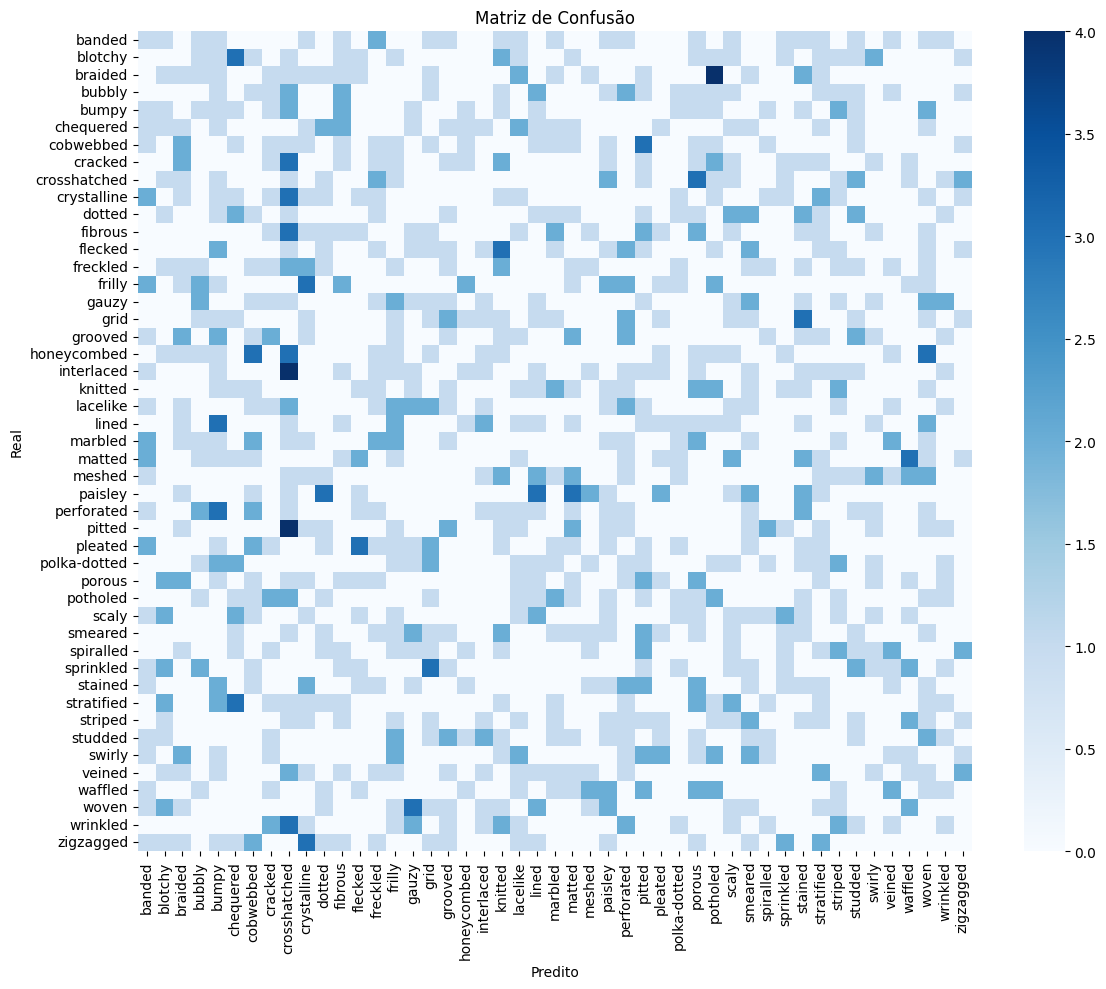

In [ ]:
#@title **8. Avaliação e Matriz de Confusão**
# Avaliação final
val_preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys(), annot=False)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


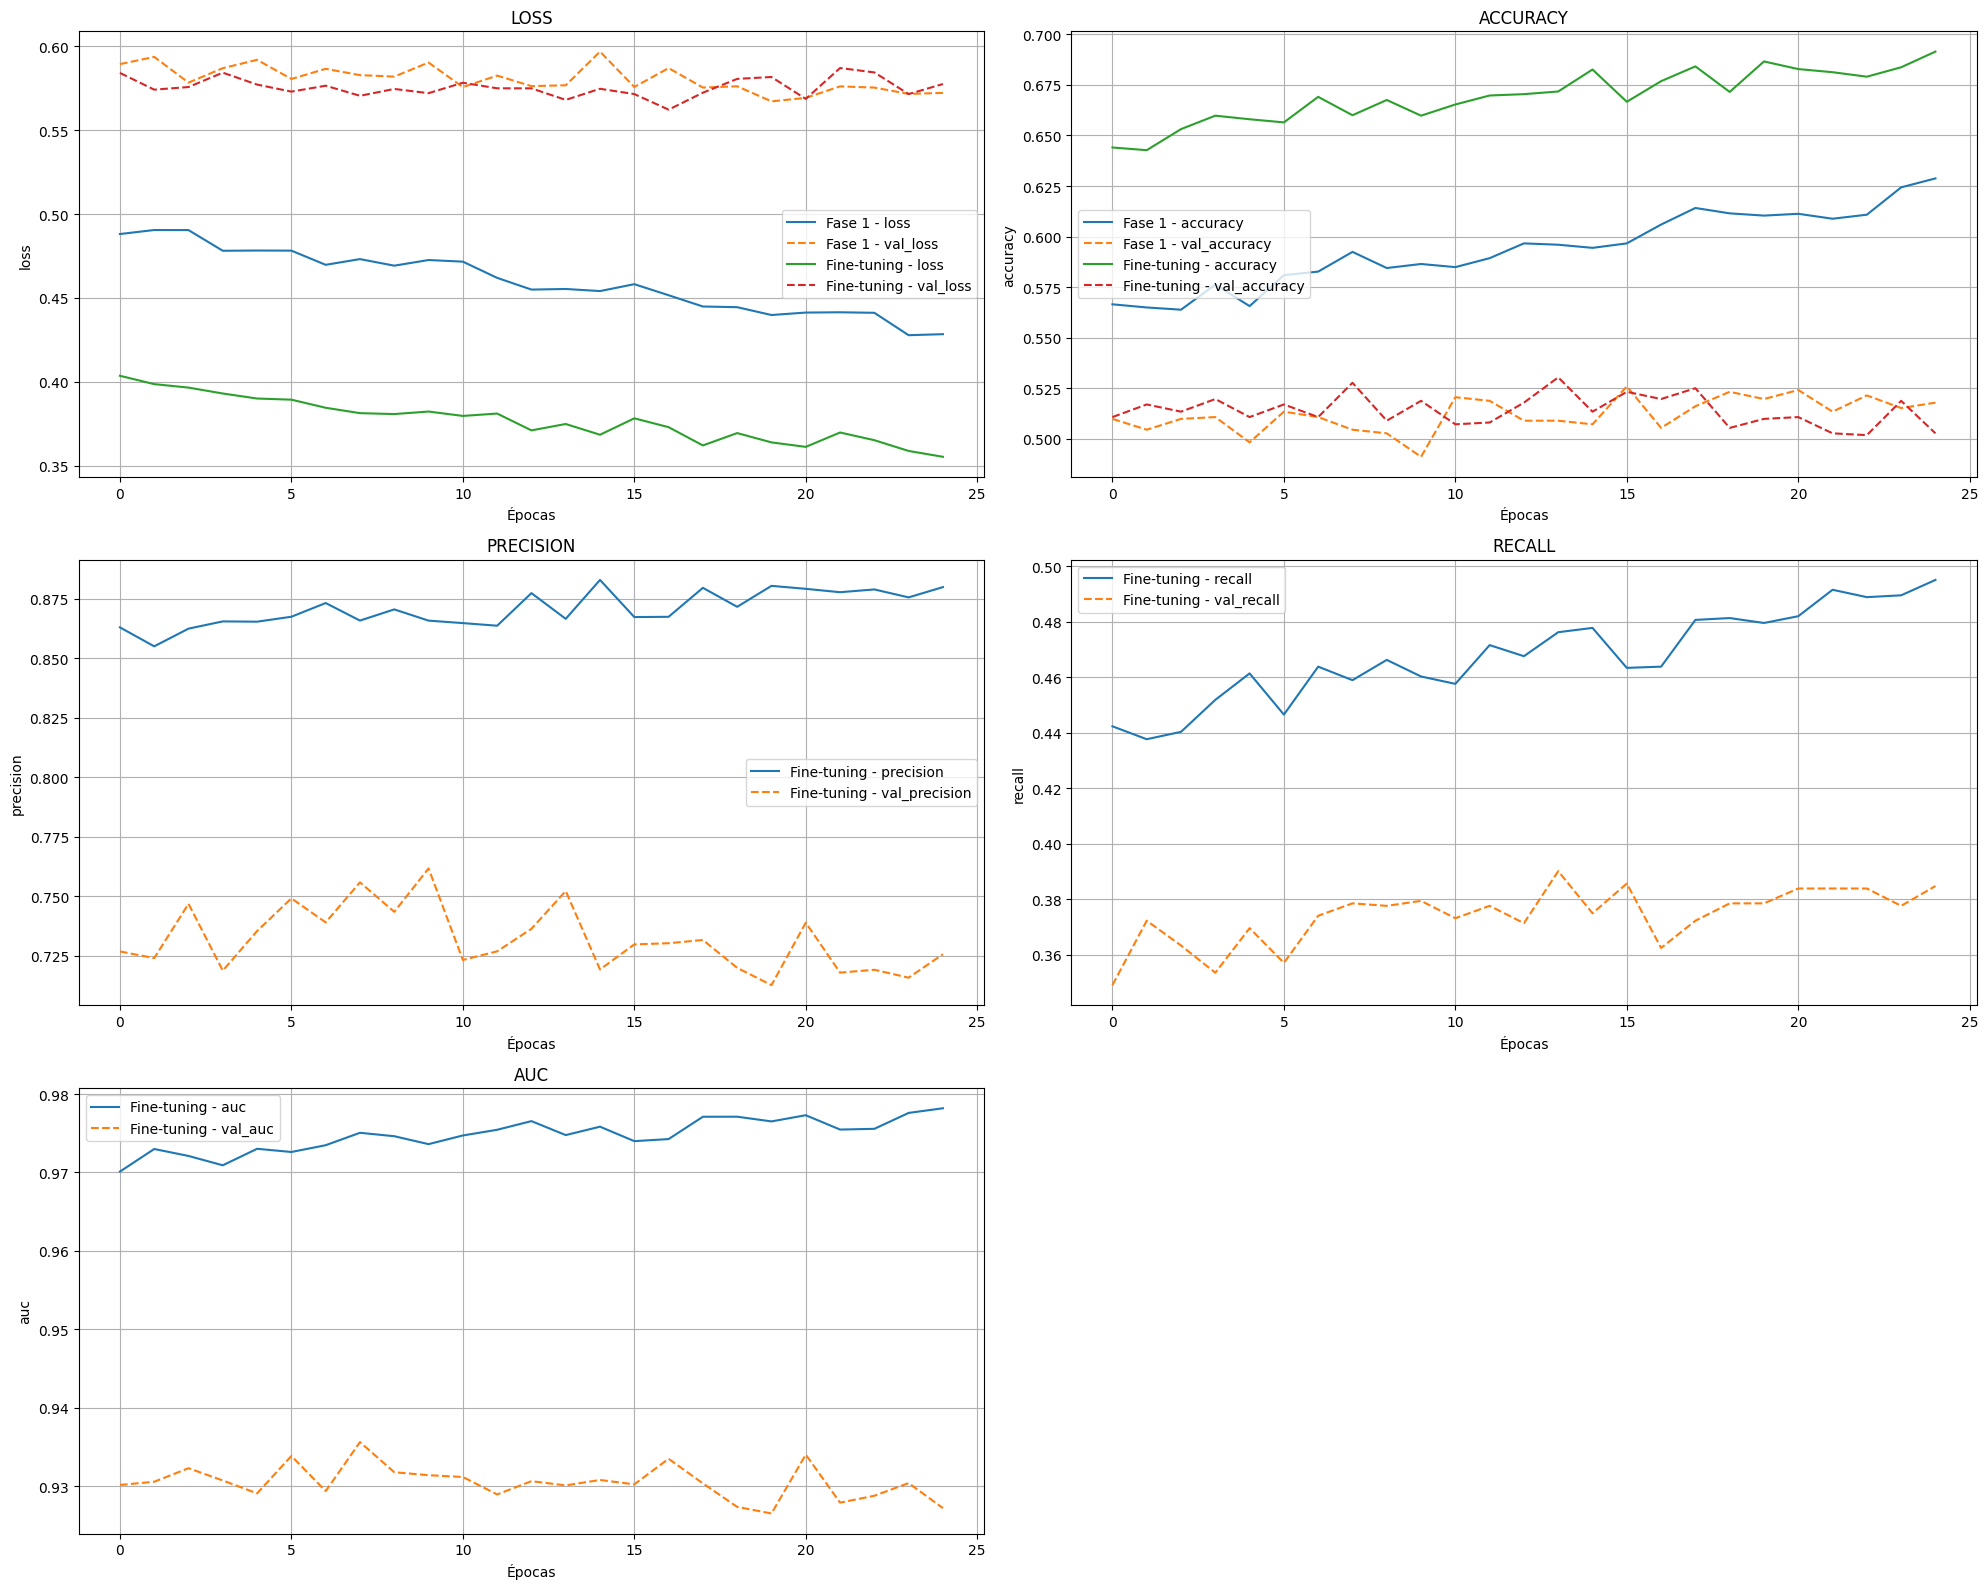

In [ ]:
#@title **9. Gráficos de Desempenho (Loss, Accuracy, etc.)**
def plot_metrics(histories, labels):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
    plt.figure(figsize=(20, 16))

    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i + 1)
        for history, label in zip(histories, labels):
            if metric in history.history:
                plt.plot(history.history[metric], label=f'{label} - {metric}')
            if f'val_{metric}' in history.history:
                plt.plot(history.history[f'val_{metric}'], linestyle='--', label=f'{label} - val_{metric}')
        plt.title(metric.upper())
        plt.xlabel('Épocas')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics([history, history_fine], ['Fase 1', 'Fine-tuning'])




Exemplo de Análise de Ativações


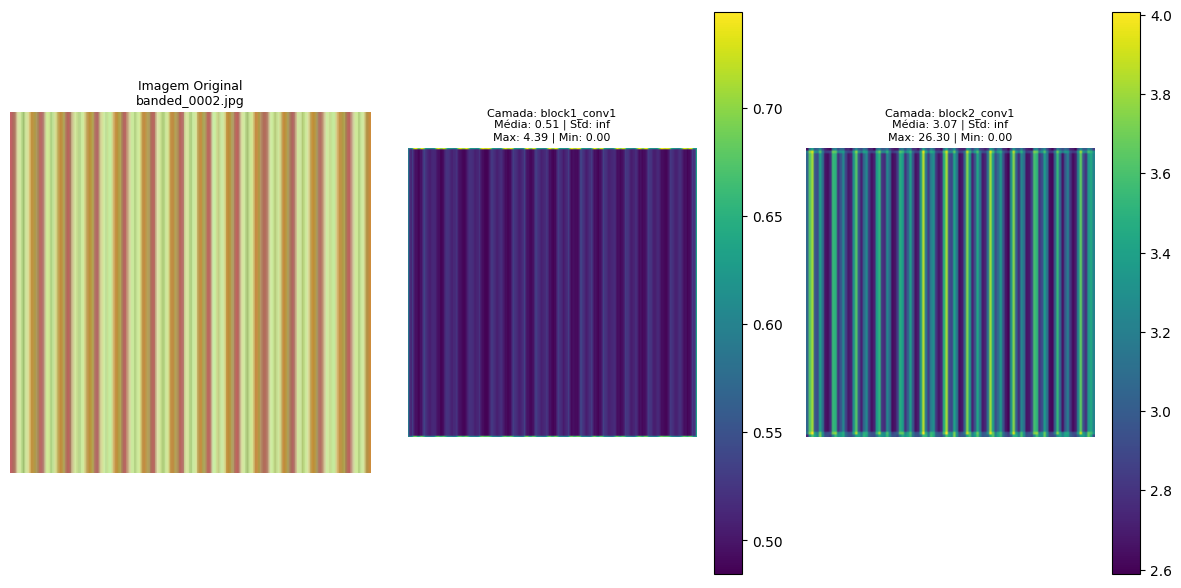


Visualização Detalhada dos Filtros por Camada


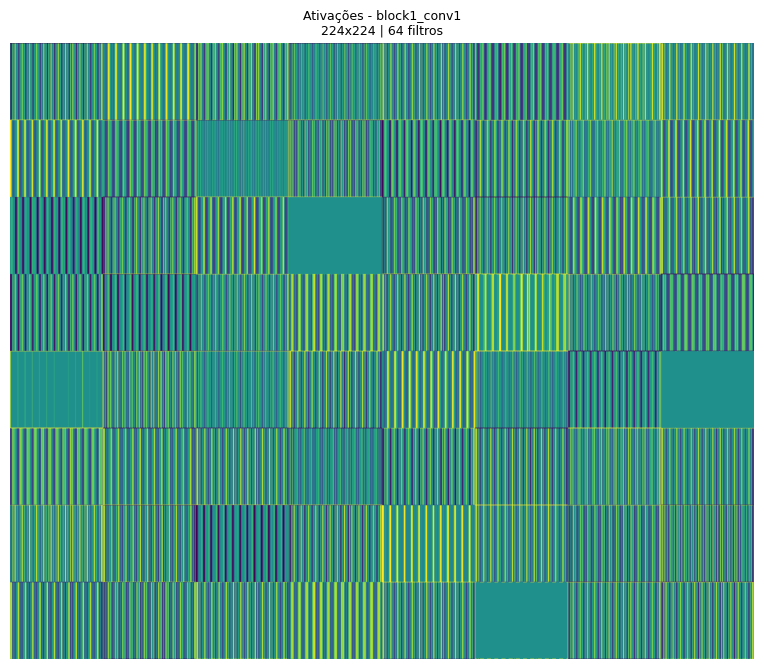

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


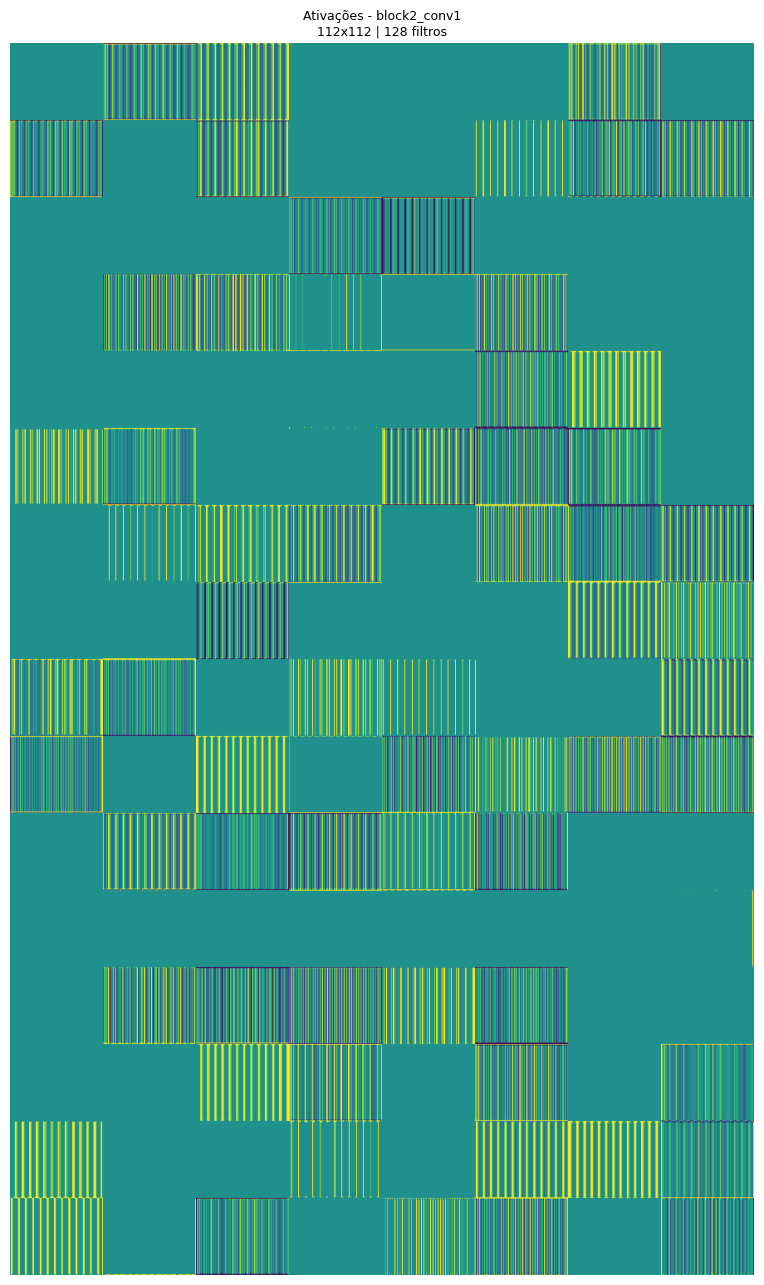


Estatísticas de Ativação
| Camada       |    Média |   Desvio Padrão |   Máximo |   Mínimo |
|:-------------|---------:|----------------:|---------:|---------:|
| block1_conv1 | 0.510254 |             inf |  4.39453 |        0 |
| block2_conv1 | 3.06836  |             inf | 26.2969  |        0 |


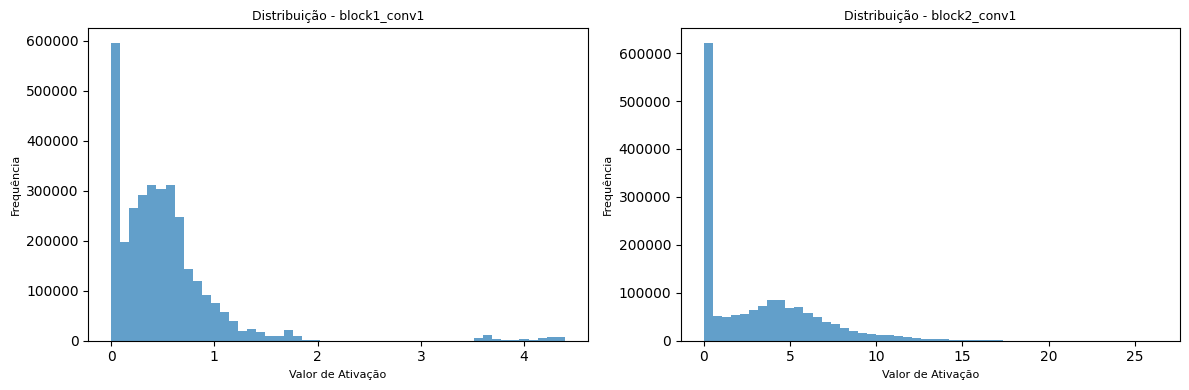

In [ ]:
#@title **10. Visualização aprimorada de ativações com análise quantitativa**
def visualize_activations(model, img_path, layer_names, figsize=(15, 10)):
    # Verificar número de camadas
    if len(layer_names) > 4 or len(layer_names) < 1:
        raise ValueError("Forneça entre 1 e 4 nomes de camadas")

    try:
        # Pré-processamento da imagem
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Criar modelo de ativações
        layer_outputs = [model.get_layer(name).output for name in layer_names]
        activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

        # Obter ativações
        activations = activation_model.predict(img_array, verbose=0)

        # Configurar layout dinâmico
        n_rows = 2 if len(layer_names) > 2 else 1
        n_cols = min(2, len(layer_names))

        plt.figure(figsize=figsize)

        # Plotar imagem original
        plt.subplot(n_rows, n_cols + 1, 1)
        plt.imshow(img)
        plt.title(f'Imagem Original\n{os.path.basename(img_path)}', fontsize=9)
        plt.axis('off')

        # Análise estatística das ativações
        activation_stats = []

        # Plotar ativações para cada camada
        for i, (layer_name, layer_activation) in enumerate(zip(layer_names, activations)):
            plt.subplot(n_rows, n_cols + 1, i + 2)

            # Calcular estatísticas com tratamento de overflow
            with np.errstate(all='ignore'):
                mean_act = np.mean(layer_activation)
                std_act = np.std(layer_activation)
                max_act = np.max(layer_activation)
                min_act = np.min(layer_activation)

            activation_stats.append([layer_name, mean_act, std_act, max_act, min_act])

            # Visualizar mapa médio de ativação
            avg_activation = np.mean(layer_activation[0], axis=-1)
            plt.imshow(avg_activation, cmap='viridis')
            plt.colorbar()

            title = (f'Camada: {layer_name}\n'
                    f'Média: {mean_act:.2f} | Std: {std_act:.2f}\n'
                    f'Max: {max_act:.2f} | Min: {min_act:.2f}')
            plt.title(title, fontsize=8)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Visualização detalhada dos filtros
        print("\n\033[1mVisualização Detalhada dos Filtros por Camada\033[0m")
        print("="*60)

        for layer_name, layer_activation in zip(layer_names, activations):
            n_filters = layer_activation.shape[-1]
            size = layer_activation.shape[1]

            # Configurar grade de visualização
            n_cols = 8
            n_rows = int(np.ceil(n_filters / n_cols))
            display_grid = np.zeros((size * n_rows, size * n_cols))

            # Preencher grade com filtros
            for col in range(n_cols):
                for row in range(n_rows):
                    channel_idx = row * n_cols + col
                    if channel_idx < n_filters:
                        channel_img = layer_activation[0, :, :, channel_idx]

                        # Normalização robusta
                        channel_img = (channel_img - np.median(channel_img))
                        channel_img = channel_img / (np.std(channel_img) + 1e-5) * 64 + 128
                        channel_img = np.clip(channel_img, 0, 255).astype('uint8')

                        display_grid[row*size:(row+1)*size, col*size:(col+1)*size] = channel_img

            # Plotar todos os filtros
            plt.figure(figsize=(n_cols*1.2, n_rows*1.0))
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.title(f'Ativações - {layer_name}\n{size}x{size} | {n_filters} filtros', fontsize=9)
            plt.axis('off')
            plt.show()

        # Tabela de estatísticas
        print("\n\033[1mEstatísticas de Ativação\033[0m")
        print("="*60)
        stats_df = pd.DataFrame(activation_stats,
                              columns=['Camada', 'Média', 'Desvio Padrão', 'Máximo', 'Mínimo'])
        print(stats_df.to_markdown(index=False))

        # Análise de distribuição
        plt.figure(figsize=(12, 4))
        for i, (layer_name, layer_activation) in enumerate(zip(layer_names, activations)):
            plt.subplot(1, len(layer_names), i+1)
            plt.hist(layer_activation.flatten(), bins=50, alpha=0.7)
            plt.title(f'Distribuição - {layer_name}', fontsize=9)
            plt.xlabel('Valor de Ativação', fontsize=8)
            plt.ylabel('Frequência', fontsize=8)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"\n\033[1;31mErro na visualização:\033[0m {str(e)}")
        print("\nSolução:")
        print("1. Verifique os nomes das camadas")
        print("2. Confira o caminho da imagem")
        print("3. Valide as dimensões da imagem de entrada")

# Exemplo de uso
if hasattr(val_generator, 'filepaths') and len(val_generator.filepaths) > 0:
    print("\n\033[1mExemplo de Análise de Ativações\033[0m")
    print("="*60)
    visualize_activations(
        model,
        val_generator.filepaths[0],
        layer_names=['block1_conv1', 'block2_conv1'],
        figsize=(12, 6)
    )
else:
    print("\nNenhuma imagem encontrada no val_generator")
